# Description
The first part is focused on inferring the missing value about skin color rating using machine learning algorithm. The second part try to infer wether referees' behavior change depending of the skin-color of the player.

Let start by doing some imports.

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt                         # Matplotlib's pyplot: MATLAB-like syntax
import seaborn as sns                                   # For pretty plots

## Skin-color inferring
First, let have a look to [mathewzila's suggestion](https://github.com/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) where the dataset is a disaggregate version of `data/CrowdstormingDataJuly1st.csv`. By _disaggregate_, we means that there is one observation per game between a player and a referee (in place of one observation per dyad).

Depending of the computations, this dataset might be a better option. Both will be imported in order to do some comparison.

In [2]:
df = pd.read_csv(os.path.join('data', 'CrowdstormingDataJuly1st.csv'))
print(df.head(10))

          playerShort              player               club leagueCountry  \
0       lucas-wilchez       Lucas Wilchez      Real Zaragoza         Spain   
1          john-utaka          John Utaka    Montpellier HSC        France   
2         abdon-prats         Abdón Prats       RCD Mallorca         Spain   
3          pablo-mari          Pablo Marí       RCD Mallorca         Spain   
4          ruben-pena          Rubén Peña    Real Valladolid         Spain   
5        aaron-hughes        Aaron Hughes          Fulham FC       England   
6  aleksandar-kolarov  Aleksandar Kolarov    Manchester City       England   
7    alexander-tettey    Alexander Tettey       Norwich City       England   
8   anders-lindegaard   Anders Lindegaard  Manchester United       England   
9        andreas-beck        Andreas Beck    1899 Hoffenheim       Germany   

     birthday  height  weight              position  games  victories  \
0  31.08.1983   177.0    72.0  Attacking Midfielder      1          

In [3]:
dfd = pd.read_csv(os.path.join('data', 'crowdstorm_disaggregated.csv'))
dfd.head(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone,allreds,allredsStrict,refCount
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375,0,0,1
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750,0,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN,0,0,3
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,0,0,30
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125,0,0,30
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000,0,0,30
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250,0,0,30
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000,0,0,30


In [4]:
df_cols = set(df.columns)
dfd_cols = set(dfd.columns)

print("Number of lost columns: {}".format(len(df_cols - dfd_cols)))

Number of lost columns: 0


As we can see, the deaggregated dataset doesn't remove any columns from the base data set.

In [5]:
print("New columns: {}".format(dfd_cols - df_cols))

New columns: {'allreds', 'allredsStrict', 'refCount', 'skintone'}


As we can see, new columns are created. Based on [source code](https://osf.io/w7tds/),

- allredsStrict: If player has received a red without a yellow
- allreds: If player has received a red during this game (either because he had a yellow one before, or if he's directly received a red)
- skintone: Average of rater1 and rater2 for this player
- refCount: Number of dyads per referee (thus, how many player the referee is linked to)

All are indicator variable (either 1 if true, 0 o.w.)

**Remark**: the field `games` (i.e. count the number of match between the player and the referee) is redundant on `dfd`, since there is one observation per game.

In [6]:
print("All fields: {}".format(dfd.columns))

All fields: Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp', 'skintone', 'allreds', 'allredsStrict',
       'refCount'],
      dtype='object')


Let add a `skintone` field to the aggregated version of the data

In [7]:
df['skintone'] = 0.5 * (df['rater1']+df['rater2'])
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN


### Look on skintone
As mentioned before, `skintone` is the mean between the two skin-color ratings

In [8]:
df_skinton = df[["playerShort", "skintone"]].reset_index().groupby('playerShort', axis=0).mean()
mean_skin = set(df_skinton['skintone'].dropna().unique().tolist())

unique_skin = set(df['skintone'].dropna().unique().tolist())

print("Values not in both: {}".format(mean_skin.symmetric_difference(unique_skin)))


Values not in both: set()


One error in the dataset might have been to have several different `skintone` value for the same user. As the previous code suggests, the mean of the `skintone` over a player doesn't create new value (suggesting that all the `skintone` for a player are the same).

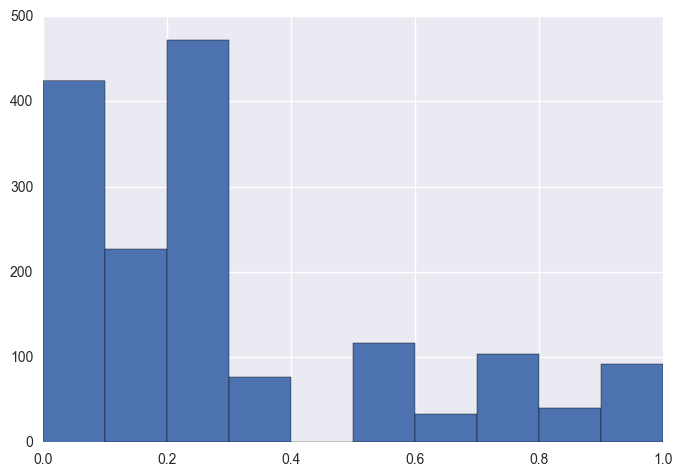

In [9]:
df_skinton['skintone'].dropna().hist()

As we can see, there are more players with a white skin than with a dark one. This need to be taken into consideration for the analysis.

### Information about players

In [10]:
referee_per_player = df.groupby('playerShort').count()['player']
referee_per_player.describe()

count    2053.000000
mean       71.129079
std        36.171246
min         1.000000
25%        45.000000
50%        67.000000
75%        92.000000
max       202.000000
Name: player, dtype: float64

We can see that player have played with a lot of different referee, in general. 

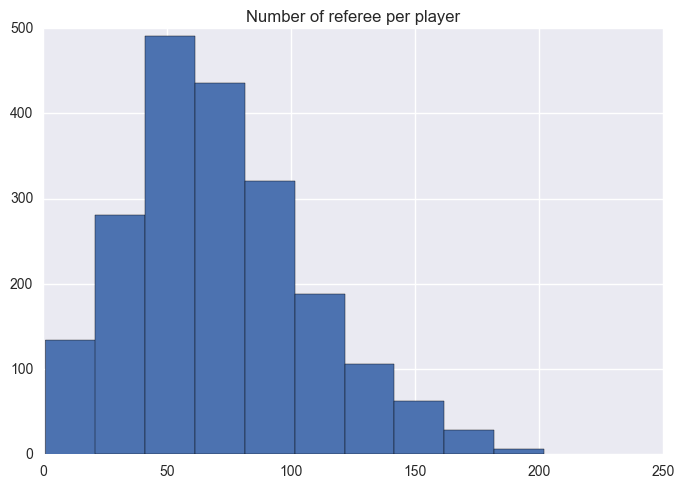

In [11]:
referee_per_player.hist()
plt.title('Number of referee per player')

One issue that might arise is for player having played with only a few referee. Let arbitrarly check for player have played with less than 5 different referees

In [12]:
(referee_per_player < 5).sum()

39

Let see the full data for these players

In [13]:
player_low_n_referees = df.set_index('playerShort')[referee_per_player < 5]
player_low_referee_ratio = player_low_n_referees['skintone'].isnull().mean()

print("P(no skintone | player has less 5 different referees) = {:0.1f}%".format(player_low_referee_ratio * 100))

P(no skintone | player has less 5 different referees) = 79.7%


/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


As we can see, we don't have skintone information for roughly 80% of the players that have less than 5 different referees. This means that it might be hard to predict the skintone for these players.

The situation might be very significant for player having only one referee linked to it.

In [14]:
player_one_referee = df.set_index('playerShort')[referee_per_player == 1]
player_one_referee_ratio = player_one_referee['skintone'].isnull().mean()

print("P(no skintone information | player has only one referee linked to him) = {:0.1f}%".format(player_one_referee_ratio*100))

P(no skintone information | player has only one referee linked to him) = 77.8%


/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


For these players, it might be harder to infer skintone.

### Numerize categories
Some field are categories but with a string representation. This breaks the random forest algorithm. In this part, we categorize the field as numeric value. 

** Remark **: Using numeric field has the issue of being ordered (where the categories aren't ordered). But, one alternative is to use dummy features. At this part of the process, dummies features would add a lot of explanatory variable. Therefore, we don't create dummy features yet.

In [15]:
LABEL_FIELDS = ['club', 'leagueCountry', 'position', 'Alpha_3']
UNKNOWN_LABEL = 'MISSING'

label_encoders = {}

from sklearn.preprocessing import LabelEncoder

df_categorized = df.copy()

for label in LABEL_FIELDS:
    encoder = LabelEncoder()
    values = df_categorized[label].fillna(UNKNOWN_LABEL, inplace=False)
    encoder.fit(values)
    transformed = encoder.transform(values)
    df_categorized[label] = transformed
    
    label_encoders[label] = encoder
    
    
# Special case for the skintone where we need to keep NaN values
encoder = LabelEncoder()
skintone = df_categorized['skintone']
skintone = skintone[skintone.notnull()]
encoder.fit(skintone)
df_categorized.loc[skintone.index, 'skintone'] = encoder.transform(skintone)
label_encoders['skintone'] = encoder

df_categorized.head(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone
0,lucas-wilchez,Lucas Wilchez,82,3,31.08.1983,177.0,72.0,0,1,0,...,1,1,60,0.326391,712.0,0.000564,0.396000,750.0,0.002696,3.0
1,john-utaka,John Utaka,62,1,08.01.1982,179.0,82.0,12,1,0,...,2,2,159,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,6.0
2,abdon-prats,Abdón Prats,73,3,17.12.1992,181.0,79.0,9,1,0,...,3,3,47,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
3,pablo-mari,Pablo Marí,73,3,31.08.1993,191.0,87.0,1,1,1,...,3,3,47,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
4,ruben-pena,Rubén Peña,81,3,18.07.1991,172.0,70.0,11,1,1,...,3,3,47,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,NaN
5,aaron-hughes,Aaron Hughes,42,0,08.11.1979,182.0,71.0,1,1,0,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.0
6,aleksandar-kolarov,Aleksandar Kolarov,59,0,10.11.1985,187.0,80.0,6,1,1,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.0
7,alexander-tettey,Alexander Tettey,65,0,04.04.1986,180.0,68.0,4,1,0,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,8.0
8,anders-lindegaard,Anders Lindegaard,60,0,13.04.1984,193.0,80.0,5,1,0,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,2.0
9,andreas-beck,Andreas Beck,2,2,13.03.1987,180.0,70.0,10,1,1,...,4,4,89,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.0


# Predicting
This part focuses on predicting the `skintone`.

## Baseline
First, let try to do a naive classification with the metric:
$$
cost(p) = \sum_{a \in A(p)} \cfrac{IAT(a)(\text{Yellow}(p, a) + 3\text{Reds}(p,a))}{\sum_{a\in A(p)} \text{Game}(a, p)},
$$
where $IAT(a)$ is the IAT of the referee $a$, Yellow$(p,a)$ is the number of yellow cards given by $a$ to player $p$, and reds is the number of red cards (similarly than for the yellow), Game$(a,p)$ is the number of games played between $p$ and $a$.

We slighlty count that reds are more importants then yellows. Also, note that with this metric the red cards reveived by successive yellow cards are counted more than red cards given directly.

In [16]:
with pd.option_context('display.max_columns', 100):
    print(df_categorized.head(5))

     playerShort         player  club  leagueCountry    birthday  height  \
0  lucas-wilchez  Lucas Wilchez    82              3  31.08.1983   177.0   
1     john-utaka     John Utaka    62              1  08.01.1982   179.0   
2    abdon-prats    Abdón Prats    73              3  17.12.1992   181.0   
3     pablo-mari     Pablo Marí    73              3  31.08.1993   191.0   
4     ruben-pena     Rubén Peña    81              3  18.07.1991   172.0   

   weight  position  games  victories  ties  defeats  goals  yellowCards  \
0    72.0         0      1          0     0        1      0            0   
1    82.0        12      1          0     0        1      0            1   
2    79.0         9      1          0     1        0      0            1   
3    87.0         1      1          1     0        0      0            0   
4    70.0        11      1          1     0        0      0            0   

   yellowReds  redCards    photoID  rater1  rater2  refNum  refCountry  \
0           

In [17]:
df_subset = df_categorized[['playerShort', 'club', 'leagueCountry', 'position','games', 'yellowCards', 'redCards', 'meanIAT', 'skintone']].copy()

for f in ['meanIAT', 'yellowCards', 'redCards']:
    df_subset[f].fillna(0, inplace=True)

df_subset["cost"] = df_subset['meanIAT']*(df_subset['yellowCards'] + 3*df_subset['redCards']) / df_subset['games']

In [18]:
def check_field_uniqueness_per_player(df, field):
    """
    Check if the field is unique on a user basis
    Example:
      - Player one: [1,1,1,1]  -> Unique 
      - Player two: [1,1,1,2]  -> Non-unique
      - Player three: [2,2,2]  -> Unique (even if not the same as player one)

    Return if uniqueness holds for every player.
    """
    fields = list(set(['playerShort', field]))
    number_different_value_per_player = df[fields].groupby('playerShort')[field].nunique()
        
    return not any(number_different_value_per_player > 1)

non_unique_fields = []
for f in ['club', 'leagueCountry', 'position', 'skintone']:
    if not check_field_uniqueness_per_player(df_subset, f):
        non_unique_fields.append(f)
        
if len(non_unique_fields) > 0:
    print("Non-unique fields: {}".format(non_unique_fields))
else:
    print("All tested fields are unique for a player")


All tested fields are unique for a player


As we can see, each tested field is unique per player. This means that the data is quite clean (there is no case where the player-specific data is different between two player-referee dyad). Thus, for these fields, we can take an element of the grouped list as aggregator function.

In [19]:
def pick_first(elements):
    """
    Aggregator for fields where each element are the same
    """
    return elements.iloc[0]

In [20]:
df_grouped = df_subset.groupby('playerShort')

df_final = df_grouped.agg({
        'club': pick_first,
        'leagueCountry': pick_first,
        'position': pick_first,
        'cost': 'sum',
        'skintone': pick_first
    })


df_final.head(10)

,leagueCountry,cost,position,club,skintone
playerShort,,,,,
aaron-hughes,0,1.953444,1,42,1.0
aaron-hunt,2,3.583045,0,110,1.0
aaron-lennon,0,0.643299,11,100,2.0
aaron-ramsey,0,5.252303,3,8,0.0
abdelhamid-el-kaoutari,1,1.171792,1,62,2.0
abdon-prats,3,2.034415,9,73,NaN
abdou-dampha,1,1.179793,0,5,NaN
abdou-traore_2,1,1.332483,11,44,6.0
abdoul-camara,1,0.979174,8,40,NaN


### Training

In [21]:
def split_training_predicting(df, y_label):
    """
    Given a y_label, return the training set (where y_label != NaN), and the predict set
    (where y_label == NaN).
    """
    x_predict = df[df[y_label].isnull()].drop(y_label, 1)
    
    training = df[df[y_label].notnull()]
    y_training = training[y_label]
    x_training = training.drop(y_label, 1)
    
    return (x_training, y_training, x_predict)

(x_training, y_training, x_predict) = split_training_predicting(df_final, 'skintone')

number_of_estimators = list(range(5,100,5))
max_features = list(range(1,df_final.shape[1]))

print(max_features)

params = {
    'n_estimators': number_of_estimators,
    'max_features': max_features,
}

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

estimator = RandomForestClassifier(n_jobs=1)    # Strange, looks to work better with 1 job than with max number
gscv = GridSearchCV(estimator, params, cv=10)
cv_result = gscv.fit(x_training, list(y_training))

[1, 2, 3, 4]


In [22]:
print(cv_result.best_score_)
cv_result.best_params_

0.31356466877


{'max_features': 2, 'n_estimators': 30}

### Learning curve 
Now that we've a good set of parameter, we can plot the learning curves

<module 'matplotlib.pyplot' from '/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/matplotlib/pyplot.py'>

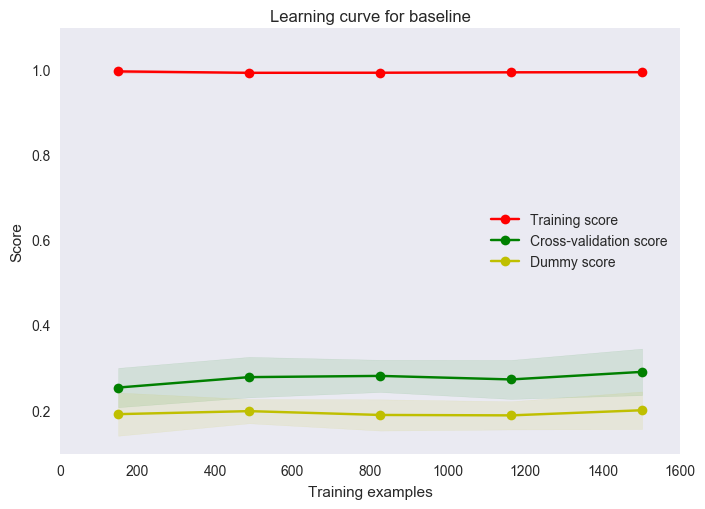

In [29]:
import helpers

from sklearn.dummy import DummyClassifier

estimator = RandomForestClassifier(max_features=cv_result.best_params_['max_features'], n_estimators=cv_result.best_params_['n_estimators'])
dummy_estimator = DummyClassifier()

helpers.plot_learning_curve(estimator, 'Baseline classification', x_training, y_training,n_jobs=-1, cv=20, dummy=dummy_estimator)

As [this guide](http://scikit-learn.org/stable/modules/model_evaluation.html) explains, Scikit is based on maximizing the score. As we can see, the _Cross-validation score_ is quite low. Hoepfully, a dummy classifier is slightly less efficient.

## Regression
It's possible to interpret the skintone as a continuous value, thus we can predict it using a RandomForestRegressor.

First, we need to have continuous $y$ values:

In [31]:
df_subset['skintone'] = df['skintone'].copy()

df_grouped = df_subset.groupby('playerShort')

df_final = df_grouped.agg({
        'club': pick_first,
        'leagueCountry': pick_first,
        'position': pick_first,
        'cost': 'sum',
        'skintone': pick_first
    })


df_final.head(10)

,leagueCountry,cost,position,club,skintone
playerShort,,,,,
aaron-hughes,0,1.953444,1,42,0.125
aaron-hunt,2,3.583045,0,110,0.125
aaron-lennon,0,0.643299,11,100,0.250
aaron-ramsey,0,5.252303,3,8,0.000
abdelhamid-el-kaoutari,1,1.171792,1,62,0.250
abdon-prats,3,2.034415,9,73,NaN
abdou-dampha,1,1.179793,0,5,NaN
abdou-traore_2,1,1.332483,11,44,0.750
abdoul-camara,1,0.979174,8,40,NaN


In [32]:
(x_training, y_training, x_predict) = split_training_predicting(df_final, 'skintone')

number_of_estimators = list(range(5,100,5))
max_features = list(range(1,df_final.shape[1]))

print(max_features)

params = {
    'n_estimators': number_of_estimators,
    'max_features': max_features,
}

from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()
gscv = GridSearchCV(estimator, params, cv=10)
cv_result = gscv.fit(x_training, list(y_training))

[1, 2, 3, 4]


In [34]:
print(cv_result.best_score_)
print(cv_result.best_params_)

0.015907145399
{'max_features': 1, 'n_estimators': 80}


### Learning curve

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x103165ae0, file "/Use...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/flo/anaconda3/envs/adaenv/lib/python3.5/s...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/flo/a.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x103165ae0, file "/Use...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/flo/anaconda3/envs/adaenv/lib/python3.5/s...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/flo/a.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'estimator = RandomForestRegressor(max_features=c...training,n_jobs=-1, cv=20, dummy=dummy_estimator)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-11-20T14:51:37.804963', 'msg_id': 'A9794A1BFA72442681D7F6739E17CAC5', 'msg_type': 'execute_request', 'session': '2310805B2F6D4A128C1173DDC45AFA06', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'A9794A1BFA72442681D7F6739E17CAC5', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'2310805B2F6D4A128C1173DDC45AFA06']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'estimator = RandomForestRegressor(max_features=c...training,n_jobs=-1, cv=20, dummy=dummy_estimator)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-11-20T14:51:37.804963', 'msg_id': 'A9794A1BFA72442681D7F6739E17CAC5', 'msg_type': 'execute_request', 'session': '2310805B2F6D4A128C1173DDC45AFA06', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'A9794A1BFA72442681D7F6739E17CAC5', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'2310805B2F6D4A128C1173DDC45AFA06'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'estimator = RandomForestRegressor(max_features=c...training,n_jobs=-1, cv=20, dummy=dummy_estimator)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-11-20T14:51:37.804963', 'msg_id': 'A9794A1BFA72442681D7F6739E17CAC5', 'msg_type': 'execute_request', 'session': '2310805B2F6D4A128C1173DDC45AFA06', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'A9794A1BFA72442681D7F6739E17CAC5', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='estimator = RandomForestRegressor(max_features=c...training,n_jobs=-1, cv=20, dummy=dummy_estimator)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'estimator = RandomForestRegressor(max_features=c...training,n_jobs=-1, cv=20, dummy=dummy_estimator)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('estimator = RandomForestRegressor(max_features=c...training,n_jobs=-1, cv=20, dummy=dummy_estimator)',), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('estimator = RandomForestRegressor(max_features=c...training,n_jobs=-1, cv=20, dummy=dummy_estimator)',)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='estimator = RandomForestRegressor(max_features=c...training,n_jobs=-1, cv=20, dummy=dummy_estimator)', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-36-c185615abed1>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 10de15ef0, execution_..._before_exec=None error_in_exec=None result=None>)
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])
   2826                 code = compiler(mod, cell_name, "single")
-> 2827                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x10e0a34b0, file "<ipython-input-36-c185615abed1>", line 2>
        result = <ExecutionResult object at 10de15ef0, execution_..._before_exec=None error_in_exec=None result=None>
   2828                     return True
   2829 
   2830             # Flush softspace
   2831             if softspace(sys.stdout, 0):

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x10e0a34b0, file "<ipython-input-36-c185615abed1>", line 2>, result=<ExecutionResult object at 10de15ef0, execution_..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x10e0a34b0, file "<ipython-input-36-c185615abed1>", line 2>
        self.user_global_ns = {'DummyClassifier': <class 'sklearn.dummy.DummyClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import os\nimport pandas as pd\nimport numpy as np...                               # For pretty plots', "df = pd.read_csv(os.path.join('data', 'CrowdstormingDataJuly1st.csv'))\nprint(df.head(10))", "dfd = pd.read_csv(os.path.join('data', 'crowdstorm_disaggregated.csv'))\ndfd.head(10)", 'df_cols = set(df.columns)\ndfd_cols = set(dfd.col...ost columns: {}".format(len(df_cols - dfd_cols)))', 'print("New columns: {}".format(dfd_cols - df_cols))', 'print("All fields: {}".format(dfd.columns))', "df['skintone'] = 0.5 * (df['rater1']+df['rater2'])\ndf.head()", 'df_skinton = df[["playerShort", "skintone"]].res...mat(mean_skin.symmetric_difference(unique_skin)))', "df_skinton['skintone'].dropna().hist()", "referee_per_player = df.groupby('playerShort').count()['player']\nreferee_per_player.describe()", "referee_per_player.hist()\nplt.title('Number of referee per player')", '(referee_per_player < 5).sum()', 'player_low_n_referees = df.set_index(\'playerShor...{:0.1f}%".format(player_low_referee_ratio * 100))', 'player_one_referee = df.set_index(\'playerShort\')...= {:0.1f}%".format(player_one_referee_ratio*100))', "LABEL_FIELDS = ['club', 'leagueCountry', 'positi...rs['skintone'] = encoder\n\ndf_categorized.head(10)", "with pd.option_context('display.max_columns', 100):\n    print(df_categorized.head(5))", "df_subset = df_categorized[['playerShort', 'club...] + 3*df_subset['redCards']) / df_subset['games']", 'def check_field_uniqueness_per_player(df, field)...rint("All tested fields are unique for a player")', 'def pick_first(elements):\n    """\n    Aggregator... are the same\n    """\n    return elements.iloc[0]', ...], 'LABEL_FIELDS': ['club', 'leagueCountry', 'position', 'Alpha_3'], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Out': {3:           playerShort              player       ...            0        30  

[10 rows x 32 columns], 7:      playerShort         player             club...  
4  0.001002       NaN  

[5 rows x 29 columns], 9: <matplotlib.axes._subplots.AxesSubplot object>, 10: count    2053.000000
mean       71.129079
std   ...max       202.000000
Name: player, dtype: float64, 11: <matplotlib.text.Text object>, 12: 39, 15:           playerShort              player  club ...0.0  0.013752       0.0  

[10 rows x 29 columns], 20:                         leagueCountry      cost ...            1  0.000000         5    95       7.0, 22: {'max_features': 2, 'n_estimators': 30}, 25: <module 'matplotlib.pyplot' from '/Users/flo/ana...ib/python3.5/site-packages/matplotlib/pyplot.py'>, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, 'UNKNOWN_LABEL': 'MISSING', '_':                         leagueCountry      cost ...            1  0.000000         5    95     0.875, ...}
        self.user_ns = {'DummyClassifier': <class 'sklearn.dummy.DummyClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import os\nimport pandas as pd\nimport numpy as np...                               # For pretty plots', "df = pd.read_csv(os.path.join('data', 'CrowdstormingDataJuly1st.csv'))\nprint(df.head(10))", "dfd = pd.read_csv(os.path.join('data', 'crowdstorm_disaggregated.csv'))\ndfd.head(10)", 'df_cols = set(df.columns)\ndfd_cols = set(dfd.col...ost columns: {}".format(len(df_cols - dfd_cols)))', 'print("New columns: {}".format(dfd_cols - df_cols))', 'print("All fields: {}".format(dfd.columns))', "df['skintone'] = 0.5 * (df['rater1']+df['rater2'])\ndf.head()", 'df_skinton = df[["playerShort", "skintone"]].res...mat(mean_skin.symmetric_difference(unique_skin)))', "df_skinton['skintone'].dropna().hist()", "referee_per_player = df.groupby('playerShort').count()['player']\nreferee_per_player.describe()", "referee_per_player.hist()\nplt.title('Number of referee per player')", '(referee_per_player < 5).sum()', 'player_low_n_referees = df.set_index(\'playerShor...{:0.1f}%".format(player_low_referee_ratio * 100))', 'player_one_referee = df.set_index(\'playerShort\')...= {:0.1f}%".format(player_one_referee_ratio*100))', "LABEL_FIELDS = ['club', 'leagueCountry', 'positi...rs['skintone'] = encoder\n\ndf_categorized.head(10)", "with pd.option_context('display.max_columns', 100):\n    print(df_categorized.head(5))", "df_subset = df_categorized[['playerShort', 'club...] + 3*df_subset['redCards']) / df_subset['games']", 'def check_field_uniqueness_per_player(df, field)...rint("All tested fields are unique for a player")', 'def pick_first(elements):\n    """\n    Aggregator... are the same\n    """\n    return elements.iloc[0]', ...], 'LABEL_FIELDS': ['club', 'leagueCountry', 'position', 'Alpha_3'], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Out': {3:           playerShort              player       ...            0        30  

[10 rows x 32 columns], 7:      playerShort         player             club...  
4  0.001002       NaN  

[5 rows x 29 columns], 9: <matplotlib.axes._subplots.AxesSubplot object>, 10: count    2053.000000
mean       71.129079
std   ...max       202.000000
Name: player, dtype: float64, 11: <matplotlib.text.Text object>, 12: 39, 15:           playerShort              player  club ...0.0  0.013752       0.0  

[10 rows x 29 columns], 20:                         leagueCountry      cost ...            1  0.000000         5    95       7.0, 22: {'max_features': 2, 'n_estimators': 30}, 25: <module 'matplotlib.pyplot' from '/Users/flo/ana...ib/python3.5/site-packages/matplotlib/pyplot.py'>, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomForestRegressor': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, 'UNKNOWN_LABEL': 'MISSING', '_':                         leagueCountry      cost ...            1  0.000000         5    95     0.875, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/Users/flo/Documents/Etudes/EPFL/ma3/ada/ada-homeworks/04 - Applied ML/<ipython-input-36-c185615abed1> in <module>()
      1 
----> 2 
      3 
      4 
      5 estimator = RandomForestRegressor(max_features=cv_result.best_params_['max_features'], n_estimators=cv_result.best_params_['n_estimators'])
      6 helpers.plot_learning_curve(estimator, 'Baseline regression', x_training, y_training,n_jobs=-1, cv=20, dummy=dummy_estimator)
      7 
      8 
      9 
     10 

...........................................................................
/Users/flo/Documents/Etudes/EPFL/ma3/ada/ada-homeworks/04 - Applied ML/helpers.py in plot_learning_curve(estimator=RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), title='Baseline regression', X=                        leagueCountry       cost...2.052402         4    80

[1585 rows x 4 columns], y=playerShort
aaron-hughes              0.125
aaro...             0.000
Name: skintone, dtype: float64, ylim=None, cv=20, n_jobs=-1, train_sizes=array([ 150,  489,  827, 1166, 1505]), scoring=None, dummy=DummyClassifier(constant=None, random_state=None, strategy='stratified'))
     78              label="Cross-validation score")
     79     
     80     if dummy is not None:
     81         _, _, dummy_scores = learning_curve(
     82             dummy, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring
---> 83         )
     84         dummy_mean = np.mean(dummy_scores, axis=1)
     85         dummy_std = np.std(dummy_scores, axis=1)
     86 
     87         plt.fill_between(train_sizes, dummy_mean - dummy_std,

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in learning_curve(estimator=DummyClassifier(constant=None, random_state=None, strategy='stratified'), X=                        leagueCountry       cost...2.052402         4    80

[1585 rows x 4 columns], y=playerShort
aaron-hughes              0.125
aaro...             0.000
Name: skintone, dtype: float64, groups=None, train_sizes=array([ 150,  489,  827, 1166, 1505]), cv=KFold(n_splits=20, random_state=None, shuffle=False), scoring=None, exploit_incremental_learning=False, n_jobs=-1, pre_dispatch='all', verbose=0)
    767             scorer, verbose) for train, test in cv_iter)
    768     else:
    769         out = parallel(delayed(_fit_and_score)(
    770             clone(estimator), X, y, scorer, train[:n_train_samples], test,
    771             verbose, parameters=None, fit_params=None, return_train_score=True)
--> 772             for train, test in cv_iter
        cv_iter = [(array([  80,   81,   82, ..., 1582, 1583, 1584]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1... 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([ 80,  81,  82,  83,  84,  85,  86,  87,  ..., 152, 153, 154, 155, 156, 157,
       158, 159])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([160, 161, 162, 163, 164, 165, 166, 167, 1..., 232, 233, 234, 235, 236, 237,
       238, 239])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([240, 241, 242, 243, 244, 245, 246, 247, 2..., 312, 313, 314, 315, 316, 317,
       318, 319])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([320, 321, 322, 323, 324, 325, 326, 327, 3..., 392, 393, 394, 395, 396, 397,
       398, 399])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([400, 401, 402, 403, 404, 405, 406, 407, 4...69, 470, 471, 472, 473, 474, 475, 476, 477, 478])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([479, 480, 481, 482, 483, 484, 485, 486, 4...48, 549, 550, 551, 552, 553, 554, 555, 556, 557])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([558, 559, 560, 561, 562, 563, 564, 565, 5...27, 628, 629, 630, 631, 632, 633, 634, 635, 636])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([637, 638, 639, 640, 641, 642, 643, 644, 6...06, 707, 708, 709, 710, 711, 712, 713, 714, 715])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([716, 717, 718, 719, 720, 721, 722, 723, 7...85, 786, 787, 788, 789, 790, 791, 792, 793, 794])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([795, 796, 797, 798, 799, 800, 801, 802, 8...64, 865, 866, 867, 868, 869, 870, 871, 872, 873])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([874, 875, 876, 877, 878, 879, 880, 881, 8...43, 944, 945, 946, 947, 948, 949, 950, 951, 952])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([ 953,  954,  955,  956,  957,  958,  959,...1025, 1026, 1027, 1028, 1029,
       1030, 1031])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([1032, 1033, 1034, 1035, 1036, 1037, 1038,...1104, 1105, 1106, 1107, 1108,
       1109, 1110])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([1111, 1112, 1113, 1114, 1115, 1116, 1117,...1183, 1184, 1185, 1186, 1187,
       1188, 1189])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([1190, 1191, 1192, 1193, 1194, 1195, 1196,...1262, 1263, 1264, 1265, 1266,
       1267, 1268])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([1269, 1270, 1271, 1272, 1273, 1274, 1275,...1341, 1342, 1343, 1344, 1345,
       1346, 1347])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([1348, 1349, 1350, 1351, 1352, 1353, 1354,...1420, 1421, 1422, 1423, 1424,
       1425, 1426])), (array([   0,    1,    2, ..., 1582, 1583, 1584]), array([1427, 1428, 1429, 1430, 1431, 1432, 1433,...1499, 1500, 1501, 1502, 1503,
       1504, 1505])), (array([   0,    1,    2, ..., 1503, 1504, 1505]), array([1506, 1507, 1508, 1509, 1510, 1511, 1512,...1578, 1579, 1580, 1581, 1582,
       1583, 1584]))]
    773             for n_train_samples in train_sizes_abs)
    774         out = np.array(out)
    775         n_cv_folds = out.shape[0] // n_unique_ticks
    776         out = out.reshape(n_cv_folds, n_unique_ticks, 2)

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object learning_curve.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Nov 20 14:51:41 2016
PID: 21972        Python 3.5.2: /Users/flo/anaconda3/envs/adaenv/bin/python
...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (DummyClassifier(constant=None, random_state=None, strategy='stratified'),                         leagueCountry       cost...2.052402         4    80

[1585 rows x 4 columns], playerShort
aaron-hughes              0.125
aaro...             0.000
Name: skintone, dtype: float64, <function _passthrough_scorer>, array([ 80,  81,  82,  83,  84,  85,  86,  87,  ..., 222,
       223, 224, 225, 226, 227, 228, 229]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1... 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (DummyClassifier(constant=None, random_state=None, strategy='stratified'),                         leagueCountry       cost...2.052402         4    80

[1585 rows x 4 columns], playerShort
aaron-hughes              0.125
aaro...             0.000
Name: skintone, dtype: float64, <function _passthrough_scorer>, array([ 80,  81,  82,  83,  84,  85,  86,  87,  ..., 222,
       223, 224, 225, 226, 227, 228, 229]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1... 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]), 0)
        kwargs = {'fit_params': None, 'parameters': None, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=DummyClassifier(constant=None, random_state=None, strategy='stratified'), X=                        leagueCountry       cost...2.052402         4    80

[1585 rows x 4 columns], y=playerShort
aaron-hughes              0.125
aaro...             0.000
Name: skintone, dtype: float64, scorer=<function _passthrough_scorer>, train=array([ 80,  81,  82,  83,  84,  85,  86,  87,  ..., 222,
       223, 224, 225, 226, 227, 228, 229]), test=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1... 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]), verbose=0, parameters=None, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    255                              " numeric value. (Hint: if using 'raise', please"
    256                              " make sure that it has been spelled correctly.)")
    257 
    258     else:
    259         fit_time = time.time() - start_time
--> 260         test_score = _score(estimator, X_test, y_test, scorer)
        test_score = undefined
        estimator = DummyClassifier(constant=None, random_state=None, strategy='stratified')
        X_test =                         leagueCountry       cost...  2.031267         8    76

[80 rows x 4 columns]
        y_test = playerShort
aaron-hughes              0.125
aaro...o            0.375
Name: skintone, dtype: float64
        scorer = <function _passthrough_scorer>
    261         score_time = time.time() - start_time - fit_time
    262         if return_train_score:
    263             train_score = _score(estimator, X_train, y_train, scorer)
    264 

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/sklearn/model_selection/_validation.py in _score(estimator=DummyClassifier(constant=None, random_state=None, strategy='stratified'), X_test=                        leagueCountry       cost...  2.031267         8    76

[80 rows x 4 columns], y_test=playerShort
aaron-hughes              0.125
aaro...o            0.375
Name: skintone, dtype: float64, scorer=<function _passthrough_scorer>)
    283 def _score(estimator, X_test, y_test, scorer):
    284     """Compute the score of an estimator on a given test set."""
    285     if y_test is None:
    286         score = scorer(estimator, X_test)
    287     else:
--> 288         score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = <function _passthrough_scorer>
        estimator = DummyClassifier(constant=None, random_state=None, strategy='stratified')
        X_test =                         leagueCountry       cost...  2.031267         8    76

[80 rows x 4 columns]
        y_test = playerShort
aaron-hughes              0.125
aaro...o            0.375
Name: skintone, dtype: float64
    289     if hasattr(score, 'item'):
    290         try:
    291             # e.g. unwrap memmapped scalars
    292             score = score.item()

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/sklearn/metrics/scorer.py in _passthrough_scorer(estimator=DummyClassifier(constant=None, random_state=None, strategy='stratified'), *args=(                        leagueCountry       cost...  2.031267         8    76

[80 rows x 4 columns], playerShort
aaron-hughes              0.125
aaro...o            0.375
Name: skintone, dtype: float64), **kwargs={})
    214     return scorer
    215 
    216 
    217 def _passthrough_scorer(estimator, *args, **kwargs):
    218     """Function that wraps estimator.score"""
--> 219     return estimator.score(*args, **kwargs)
        estimator.score = <bound method ClassifierMixin.score of DummyClas...=None, random_state=None, strategy='stratified')>
        args = (                        leagueCountry       cost...  2.031267         8    76

[80 rows x 4 columns], playerShort
aaron-hughes              0.125
aaro...o            0.375
Name: skintone, dtype: float64)
        kwargs = {}
    220 
    221 
    222 def check_scoring(estimator, scoring=None, allow_none=False):
    223     """Determine scorer from user options.

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/sklearn/base.py in score(self=DummyClassifier(constant=None, random_state=None, strategy='stratified'), X=                        leagueCountry       cost...  2.031267         8    76

[80 rows x 4 columns], y=playerShort
aaron-hughes              0.125
aaro...o            0.375
Name: skintone, dtype: float64, sample_weight=None)
    344         score : float
    345             Mean accuracy of self.predict(X) wrt. y.
    346 
    347         """
    348         from .metrics import accuracy_score
--> 349         return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
        accuracy_score = <function accuracy_score>
        y = playerShort
aaron-hughes              0.125
aaro...o            0.375
Name: skintone, dtype: float64
        self.predict = <bound method DummyClassifier.predict of DummyCl...=None, random_state=None, strategy='stratified')>
        X =                         leagueCountry       cost...  2.031267         8    76

[80 rows x 4 columns]
        sample_weight = None
    350 
    351 
    352 ###############################################################################
    353 class RegressorMixin(object):

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/sklearn/metrics/classification.py in accuracy_score(y_true=playerShort
aaron-hughes              0.125
aaro...o            0.375
Name: skintone, dtype: float64, y_pred=array([ 0.25 ,  0.25 ,  0.75 ,  1.   ,  0.25 ,  ...  0.   ,  0.125,  0.75 ,  0.   ,  0.25 ,  0.75 ]), normalize=True, sample_weight=None)
    167     >>> accuracy_score(np.array([[0, 1], [1, 1]]), np.ones((2, 2)))
    168     0.5
    169     """
    170 
    171     # Compute accuracy for each possible representation
--> 172     y_type, y_true, y_pred = _check_targets(y_true, y_pred)
        y_type = undefined
        y_true = playerShort
aaron-hughes              0.125
aaro...o            0.375
Name: skintone, dtype: float64
        y_pred = array([ 0.25 ,  0.25 ,  0.75 ,  1.   ,  0.25 ,  ...  0.   ,  0.125,  0.75 ,  0.   ,  0.25 ,  0.75 ])
    173     if y_type.startswith('multilabel'):
    174         differing_labels = count_nonzero(y_true - y_pred, axis=1)
    175         score = differing_labels == 0
    176     else:

...........................................................................
/Users/flo/anaconda3/envs/adaenv/lib/python3.5/site-packages/sklearn/metrics/classification.py in _check_targets(y_true=playerShort
aaron-hughes              0.125
aaro...o            0.375
Name: skintone, dtype: float64, y_pred=array([ 0.25 ,  0.25 ,  0.75 ,  1.   ,  0.25 ,  ...  0.   ,  0.125,  0.75 ,  0.   ,  0.25 ,  0.75 ]))
     84     # We can't have more than one value on y_type => The set is no more needed
     85     y_type = y_type.pop()
     86 
     87     # No metrics support "multiclass-multioutput" format
     88     if (y_type not in ["binary", "multiclass", "multilabel-indicator"]):
---> 89         raise ValueError("{0} is not supported".format(y_type))
        y_type = 'continuous'
     90 
     91     if y_type in ["binary", "multiclass"]:
     92         y_true = column_or_1d(y_true)
     93         y_pred = column_or_1d(y_pred)

ValueError: continuous is not supported
___________________________________________________________________________

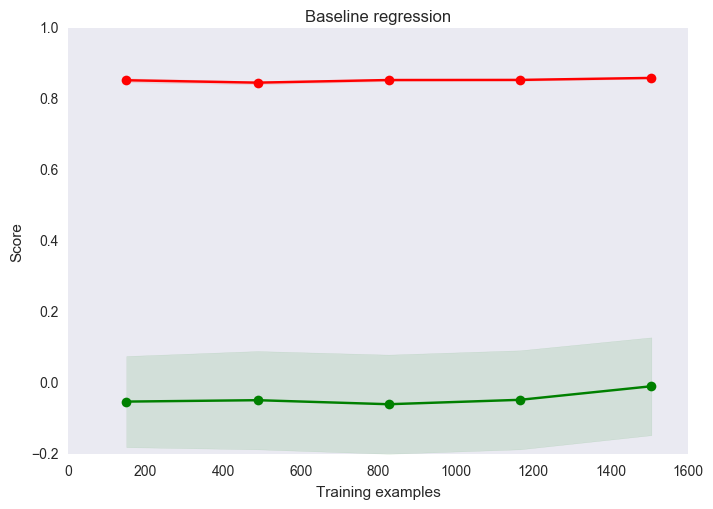

In [36]:
estimator = RandomForestRegressor(max_features=cv_result.best_params_['max_features'], n_estimators=cv_result.best_params_['n_estimators'])
helpers.plot_learning_curve(estimator, 'Baseline regression', x_training, y_training,n_jobs=-1, cv=20, dummy=dummy_estimator)